In [1]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multitag_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle
import json

In [2]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
exps_done=0
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        if df_all is None:
            df_all=_df
        else:
            _df["Run Exp Num"]=exps_done
            df_all = pd.concat([df_all, _df], ignore_index=True)
    exps_done=len(df_all["Run Exp Num"].unique())
    # print(exps_done, df_all["Run Exp Num"].unique())
df_all

0.df
1.df
2.df
3.df
4.df
5.df
6.df
7.df
8.df
9.df
10.df
11.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,1.763504e+09,1.763504e+09,"[629.93, 62.45, 63.52, 63.13, 63.9, 62.98, 64....",775,0,5
1,3,1,1.763504e+09,1.763504e+09,"[828.3, 18.96, 19.87, 18.65, 18.96, 19.19, 19....",775,0,5
2,4,1,1.763504e+09,1.763504e+09,"[760.32, 34.91, 34.75, 34.91, 36.74, 34.52, 34...",775,0,5
3,5,1,1.763504e+09,1.763504e+09,"[147.59, 9.96, 8.81, 8.66, 9.19, 9.04, 9.12, 9...",775,0,5
4,1,2,1.763504e+09,1.763504e+09,"[323.0, 24.45, 24.3, 24.68, 24.53, 24.68, 24.8...",775,0,5
...,...,...,...,...,...,...,...,...
5515,5,4,1.763508e+09,1.763508e+09,"[4.92, 7.52, 5.68, 5.91, 5.23, 5.61, 6.52, 6.8...",995,11,5
5516,1,5,1.763508e+09,1.763508e+09,"[28.95, 32.62, 32.85, 32.77, 32.92, 32.85, 32....",995,11,5
5517,2,5,1.763508e+09,1.763508e+09,"[48.71, 52.91, 56.42, 52.0, 52.76, 51.92, 51.6...",995,11,5
5518,3,5,1.763508e+09,1.763508e+09,"[146.98, 173.08, 173.15, 173.15, 173.15, 173.3...",995,11,5


In [3]:
with open("../tag_name_mapping.json", 'r') as f:
    tag_name_mapping=json.load(f)

In [4]:
tag_name_mapping

{'Tag1': 'v32-4',
 'Tag2': 'v32-5',
 'Tag3': 'v31-2',
 'Tag4': 'v31-1',
 'Tag5': 'v32-3'}

In [5]:
# time_per_phase = 10/1000  # s
# num_phases=6
# num_mpps=df_all.iloc[0]['NumMPPs']
# sampling_rate=1000
# plotting=False
# ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

# processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
#                                 "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
# processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])



# unique_exp_no=0
# phase_order=[1,3,4,6,7,8]

# for df_idx in range(len(df_all)):

#     voltages=df_all.iloc[df_idx]['Voltages (mV)']
#     phase_medians={
#         1:[],
#         3:[],
#         4:[],
#         6:[],
#         7:[],
#         8:[],
#     }
#     if plotting:
#         plt.figure(figsize=(15,5))
#     for idx,v in enumerate(ver_lines):
#         if idx<len(ver_lines)-1:
#             phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
#         if plotting:
#             # plt.subplot(len(df_all)//3+1, 3, df_idx+1)
#             if idx%num_phases==0:
#                 plt.axvline(x=v, color='b', linestyle='-')
#             else:
#                 plt.axvline(x=v, color='r', linestyle='--')
#     entry={
#         "Rx": df_all.iloc[df_idx]["Rx"],
#         "Tx":df_all.iloc[df_idx]["Tx"],
#         "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
#         "Phase1":phase_medians[1],
#         "Phase3":phase_medians[3],
#         "Phase4":phase_medians[4],
#         "Phase6":phase_medians[6],
#         "Phase7":phase_medians[7],
#         "Phase8":phase_medians[8],
#         "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
#         "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
#         "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
#     }
#     for phase in phase_order:
#         entry_aggregated={
#             "Rx":df_all.iloc[df_idx]["Rx"],
#             "Tx":df_all.iloc[df_idx]["Tx"],
#             "phase": str(phase),
#             "median": np.mean(phase_medians[phase]), # mean of medians
#             "std": np.std(phase_medians[phase]),
#             "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
#             'delta': max(phase_medians[phase])-min(phase_medians[phase]),
#             "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
#             "Unique Exp Number":unique_exp_no,
#             "allVoltages": phase_medians[phase]
#         }
#         processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
#     unique_exp_no+=1
    
#     # # Identify and print bad MPPs
#     # bad=False
#     # for k in phase_medians.keys():
#     #     assert(len(phase_medians[k])==num_mpps)
#     #     if np.std(phase_medians[k])>1:
#     #         print(f"<== Bad data found at {df_idx} df_idx at phase {k}.", end="\t")
#     #         print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
#     #         bad=True
#     # if bad and plotting:
#     #     plt.plot(voltages,'.')
#     #     plt.title(df_idx)
#     #     plt.tight_layout()
#     #     plt.ylim([np.percentile(voltages, 1), np.percentile(voltages, 99)])
#     #     plt.savefig(f"badplots/{df_idx}.pdf")
#     #     plt.clf()
#     # elif not bad and plotting:
#     #     plt.clf()
    
    
#     processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    
    
#     # if df_idx>20:
#     #     break   
# # if plotting:
# #     plt.show()
    
with open("processedDF.pkl", 'rb') as f:
    processedDF=pickle.load(f)
    
with open("processedDF_aggregated.pkl", 'rb') as f:
    processedDF_aggregated=pickle.load(f)


In [6]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,"[629.93, 62.45, 63.52, 63.13, 63.9, 62.98, 64....","[63.52, 63.97, 62.83, 63.44, 62.715]","[63.78, 63.82, 64.205, 63.67, 64.16499999999999]","[63.974999999999994, 64.775, 64.735, 64.35, 65...","[64.355, 64.05, 64.24000000000001, 64.09, 63.9]","[64.315, 63.44, 63.78, 63.86, 63.59]","[60.12, 59.32, 59.815, 59.66, 59.7]",775,0,5
1,3,1,"[828.3, 18.96, 19.87, 18.65, 18.96, 19.19, 19....","[19.04, 19.0, 18.92, 19.115000000000002, 18.88]","[19.035, 19.19, 19.265, 19.0, 19.04]","[19.115000000000002, 19.04, 19.075, 18.88, 19.15]","[18.845, 18.884999999999998, 18.845, 18.845, 1...","[18.65, 18.81, 18.65, 18.65, 18.615000000000002]","[18.08, 17.97, 17.89, 18.005, 18.43]",775,0,5
2,4,1,"[760.32, 34.91, 34.75, 34.91, 36.74, 34.52, 34...","[34.75, 34.6, 34.41, 35.36, 34.18]","[34.03, 34.144999999999996, 34.64, 34.10500000...","[34.07, 34.485, 34.56, 34.22, 34.675]","[33.760000000000005, 33.644999999999996, 34.10...","[33.53, 33.15, 34.105000000000004, 33.53, 33.72]","[32.730000000000004, 32.385000000000005, 32.08...",775,0,5
3,5,1,"[147.59, 9.96, 8.81, 8.66, 9.19, 9.04, 9.12, 9...","[9.12, 9.385, 9.114999999999998, 9.34499999999...","[8.89, 9.23, 9.5, 8.965, 9.879999999999999]","[9.155, 9.23, 9.46, 8.89, 9.65]","[8.775, 8.7, 8.81, 8.850000000000001, 8.775]","[8.74, 8.51, 8.58, 8.735, 8.58]","[8.09, 7.86, 8.01, 7.9, 8.469999999999999]",775,0,5
4,1,2,"[323.0, 24.45, 24.3, 24.68, 24.53, 24.68, 24.8...","[24.68, 24.3, 24.3, 24.605, 24.225]","[25.06, 24.869999999999997, 24.95, 25.06499999...","[20.564999999999998, 20.71, 20.49, 20.56, 20.675]","[24.99, 25.025, 24.91, 25.025, 24.835]","[25.939999999999998, 25.6, 25.79, 25.79, 25.67]","[25.98, 25.71, 25.75, 25.6, 25.79]",775,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
5515,5,4,"[4.92, 7.52, 5.68, 5.91, 5.23, 5.61, 6.52, 6.8...","[5.91, 4.84, 7.02, 7.21, 7.555]","[7.4399999999999995, 7.555, 7.25, 7.5950000000...","[6.905, 6.375, 4.77, 4.84, 4.84]","[5.23, 5.035, 6.675000000000001, 8.01, 5.535]","[6.755, 6.45, 7.365, 5.225, 5.91]","[5.65, 7.325, 7.25, 7.555, 6.18]",995,11,5
5516,1,5,"[28.95, 32.62, 32.85, 32.77, 32.92, 32.85, 32....","[32.85, 32.85, 32.85, 32.85, 33.15]","[32.85, 32.85, 32.77, 32.769999999999996, 33.53]","[32.54, 32.69, 32.69, 32.85, 34.07]","[32.655, 32.62, 32.77, 32.885000000000005, 33.99]","[32.730000000000004, 32.69, 32.77, 32.96, 33.95]","[32.85, 32.77, 32.92, 33.035, 34.03]",995,11,5
5517,2,5,"[48.71, 52.91, 56.42, 52.0, 52.76, 51.92, 51.6...","[52.15, 53.135, 52.834999999999994, 53.295, 53...","[53.94, 52.87, 53.22, 53.065, 54.055]","[52.754999999999995, 52.76, 53.025000000000006...","[52.72, 52.644999999999996, 53.25, 53.215, 53....","[52.835, 52.68, 53.06, 54.17, 53.405]","[54.59, 52.83, 54.36, 53.52, 53.33]",995,11,5
5518,3,5,"[146.98, 173.08, 173.15, 173.15, 173.15, 173.3...","[173.15, 173.34, 173.305, 173.495, 173.495]","[173.15, 173.15, 173.265, 173.45499999999998, ...","[173.46, 173.65, 173.69, 174.07, 174.3]","[173.725, 173.61, 173.8, 173.91500000000002, 1...","[173.61, 173.53, 173.65, 173.765, 174.10500000...","[173.53, 173.495, 178.3, 173.725, 173.84]",995,11,5


In [7]:
with open("processedDF_aggregated.pkl", 'wb') as f:
    pickle.dump(processedDF_aggregated,f)
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
0,2,1,1,63.295,0.464736,775000000.0,NaN,1.255,0,0,"[63.52, 63.97, 62.83, 63.44, 62.715]"
1,2,1,3,63.928,0.215884,775000000.0,NaN,0.535,0,0,"[63.78, 63.82, 64.205, 63.67, 64.16499999999999]"
2,2,1,4,64.659,0.494807,775000000.0,NaN,1.485,0,0,"[63.974999999999994, 64.775, 64.735, 64.35, 65..."
3,2,1,6,64.127,0.157213,775000000.0,NaN,0.455,0,0,"[64.355, 64.05, 64.24000000000001, 64.09, 63.9]"
4,2,1,7,63.797,0.297617,775000000.0,NaN,0.875,0,0,"[64.315, 63.44, 63.78, 63.86, 63.59]"
...,...,...,...,...,...,...,...,...,...,...,...
33115,4,5,3,137.712,0.195336,995000000.0,NaN,0.535,11,5519,"[137.635, 137.56, 137.675, 137.595, 138.095]"
33116,4,5,4,137.637,0.311474,995000000.0,NaN,0.920,11,5519,"[137.29, 137.45, 137.635, 137.6, 138.21]"
33117,4,5,6,137.749,0.186505,995000000.0,NaN,0.500,11,5519,"[137.51999999999998, 137.595, 137.9, 137.70999..."
33118,4,5,7,137.758,0.248487,995000000.0,NaN,0.765,11,5519,"[137.32999999999998, 137.83, 137.7099999999999..."


In [8]:
processedDF_aggregated[processedDF_aggregated["Experiment Number"]==1]

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
2760,2,1,1,70.671,0.374732,775000000.0,NaN,1.105,1,460,"[71.37, 70.61, 70.265, 70.46, 70.65]"
2761,2,1,3,72.208,0.787620,775000000.0,NaN,2.210,1,460,"[73.32, 71.605, 72.75, 71.11, 72.255]"
2762,2,1,4,72.610,0.629103,775000000.0,NaN,1.830,1,460,"[73.50999999999999, 72.175, 72.785, 71.68, 72.9]"
2763,2,1,6,73.030,0.441441,775000000.0,NaN,1.185,1,460,"[73.66499999999999, 72.59, 73.285, 72.47999999..."
2764,2,1,7,72.725,0.196214,775000000.0,NaN,0.535,1,460,"[72.97999999999999, 72.59, 72.9, 72.7100000000..."
...,...,...,...,...,...,...,...,...,...,...,...
5515,4,5,3,126.466,1.677598,995000000.0,NaN,4.345,1,919,"[129.815, 125.695, 125.58000000000001, 125.47,..."
5516,4,5,4,125.374,0.126902,995000000.0,NaN,0.380,1,919,"[125.19999999999999, 125.43, 125.35, 125.31, 1..."
5517,4,5,6,126.230,0.364513,995000000.0,NaN,0.995,1,919,"[126.155, 126.27000000000001, 126.57, 126.5749..."
5518,4,5,7,126.307,0.603221,995000000.0,NaN,1.600,1,919,"[126.46000000000001, 127.22, 125.62, 126.575, ..."


In [9]:
freq_range=np.array(range(775,1000,10))*1e6
all_freqs, selected_experiments_all = multitag_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False, all_available_tags=["1", "2", "3", "4", "5"], tag_name_mappings=tag_name_mapping)

# with open("no_correction_all_errs.pkl",'wb') as f:
#     pickle.dump(all_errors,f)
    
with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

# with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
#     pickle.dump(all_freqs_unwrapped,f)    

# with open("theoretical_phase.pkl",'wb') as f:
#     pickle.dump(all_freqs_theoretical,f)    

[-0.5697928139086346, 2.914194540753542]
[-0.22694433982265483, 1.3310135642752328]
[0.05245080593090523, 0.6677122728203647]
[-0.07463241657973851, 0.027026902062233456]
[3.0259705371584547, 0.687774963599718]
[2.9187817996333014, 0.17859381260750265]
[-0.46943501538448007, 0.46324198418548557]
[0.554957903565546, 0.24866243821363657]
[-1.798840301521288, 1.663515503004897]
[-3.131648012305484, 0.5922426613915076]
[-0.9432834525362267, 2.9574151981359007]
[0.46785736877454803, 1.4274464540317668]
[0.30376462803318155, 0.573698563143134]
[3.140947554574616, 3.1041640058774833]
[2.966349450267811, 0.4457073634278628]
[2.93460700745479, 0.14516260528174468]
[-2.2978891504068004, -0.2614457032344659]
[0.7890999821814557, 0.2751115232167424]
[1.0805878736994186, 2.945343560400797]
[2.322988536525079, 0.7180018792546476]
[-0.7934959188582054, 2.9177718806040915]
[-0.4795188526902821, 1.2121118324522526]
[-0.234576516758186, 0.4769891965596291]
[0.9706584565490438, 0.07380962746805507]
[2.94

In [10]:
all_freqs[915e6][1][0]['1-2']

np.float64(1.8386182435570289)

In [11]:
def getMPPSignalPlot(exp_no, tag1, tag2, freq):
    # freq in mhz
    plt.subplot(2,1,1)
    plt.plot(processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag1) & (processedDF['Tx']==tag2) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0])
    plt.title(f"Rx={tag1}, Tx={tag2}")
    
    plt.subplot(2,1,2)
    v=processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag2) & (processedDF['Tx']==tag1) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0]
    plt.plot(v)
    plt.ylim([np.percentile(v,1), np.percentile(v,99)])
    plt.title(f"Rx={tag2}, Tx={tag1}")
    
    plt.suptitle(f"Exp={exp_no}, freq={freq}")
    plt.tight_layout()
    plt.show()

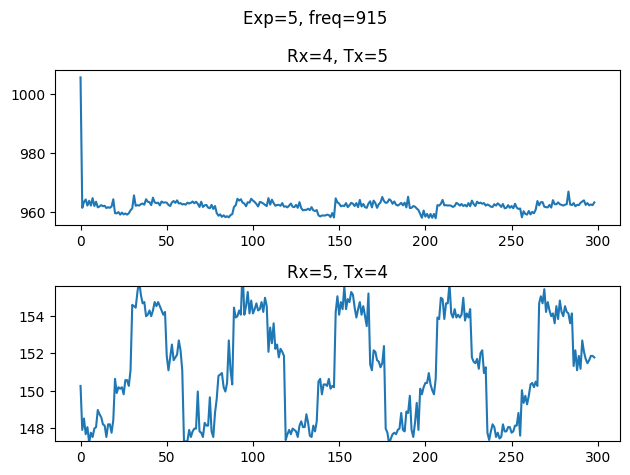

In [12]:
getMPPSignalPlot(5, 4, 5, 915)

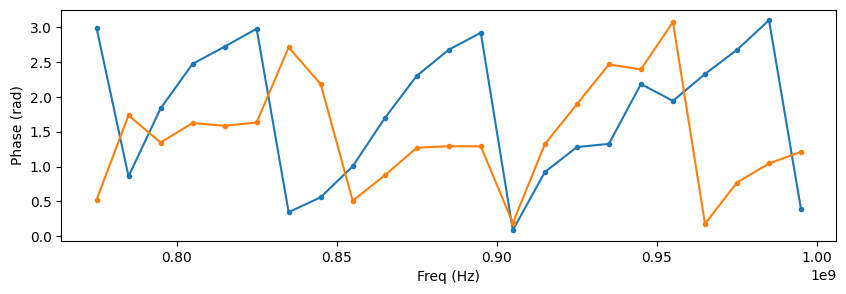

In [13]:
plt.figure(figsize=(10,3))
link1='1-5'
link2='4-5'
l1_ph=[]
l2_ph=[]
for freq in all_freqs.keys():
    exp1=4
    exp2=7
    l1_ph.append(all_freqs[freq][exp1][0][link1])
    l2_ph.append(all_freqs[freq][exp2][0][link2])
    
plt.plot(list(all_freqs.keys()),l1_ph, '.-', label="1-5, exp 0")
plt.plot(list(all_freqs.keys()),l2_ph, '.-', label="4-5, exp 0")
plt.xlabel("Freq (Hz)")
plt.ylabel("Phase (rad)")
plt.show()
# what is the relation between phase change and t2t distance.............
# get distance matrix from slam info
# ability to plot adc voltages for given experiment number and frequency.

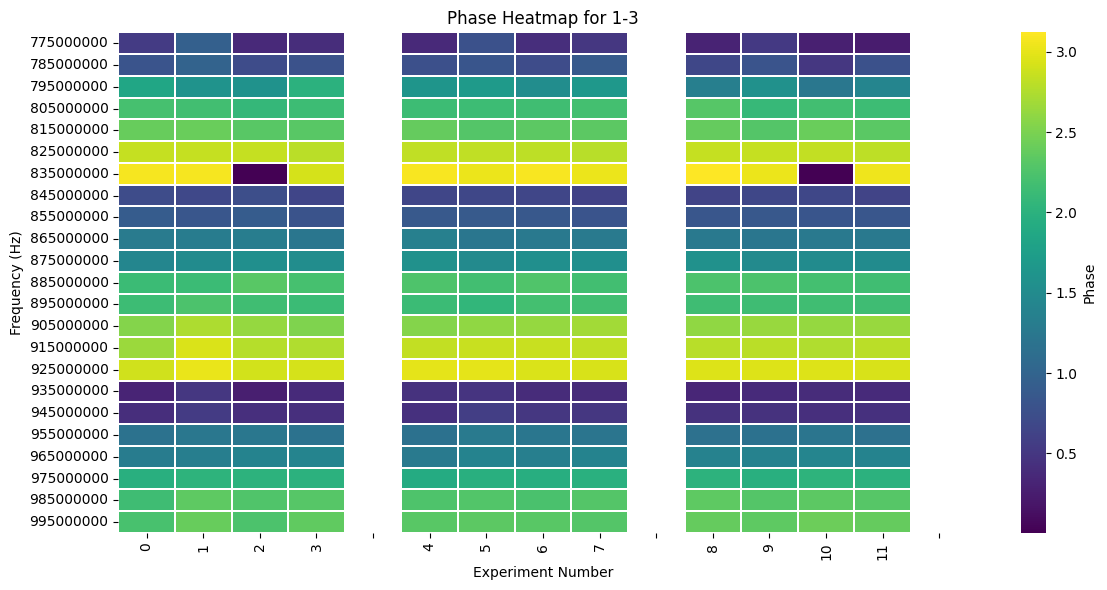

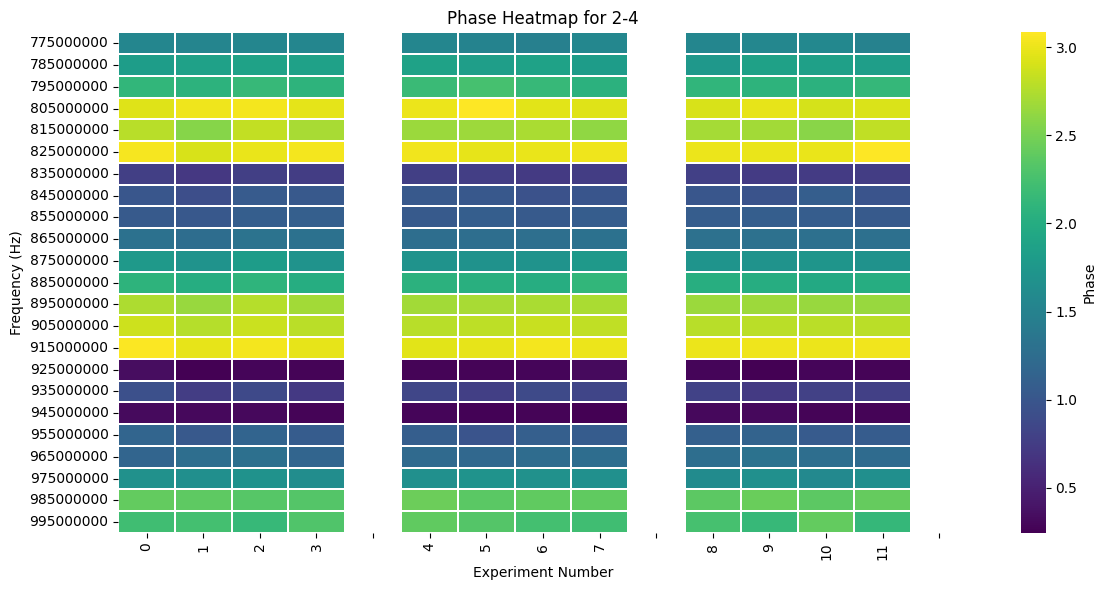

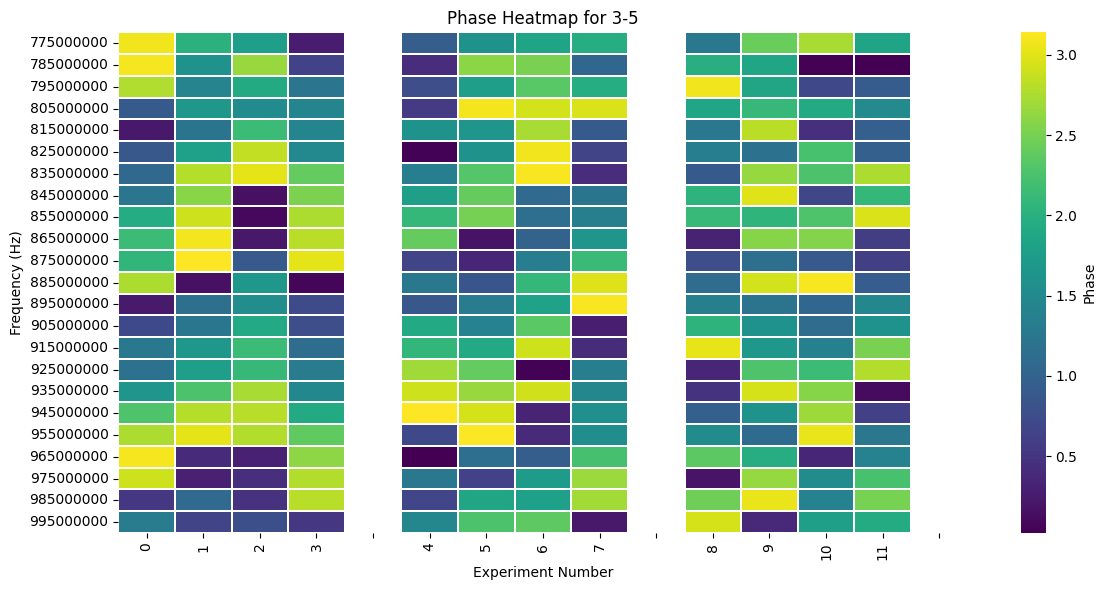

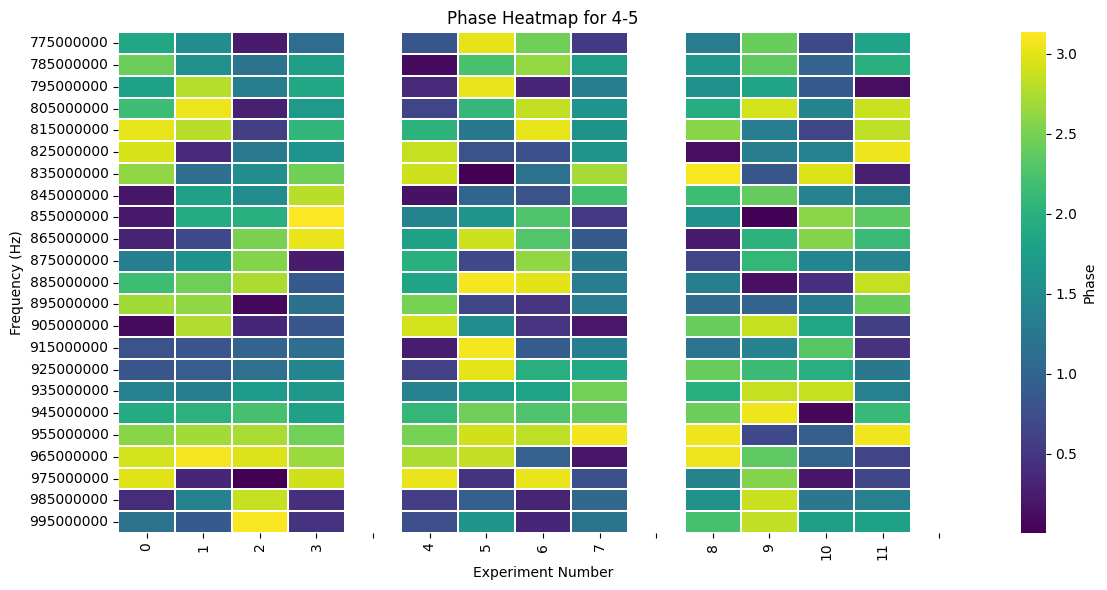

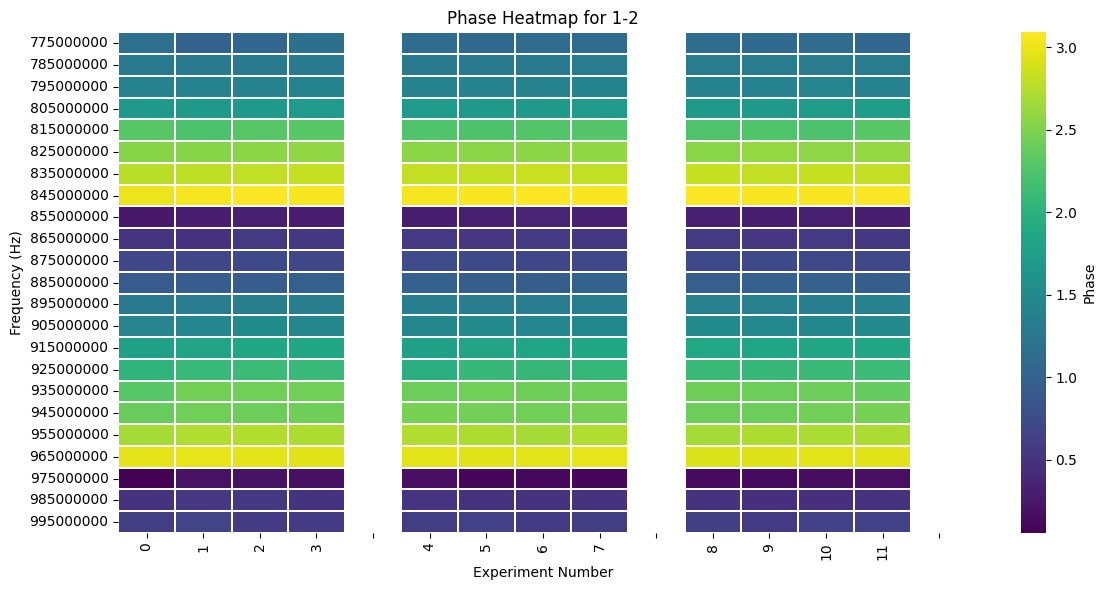

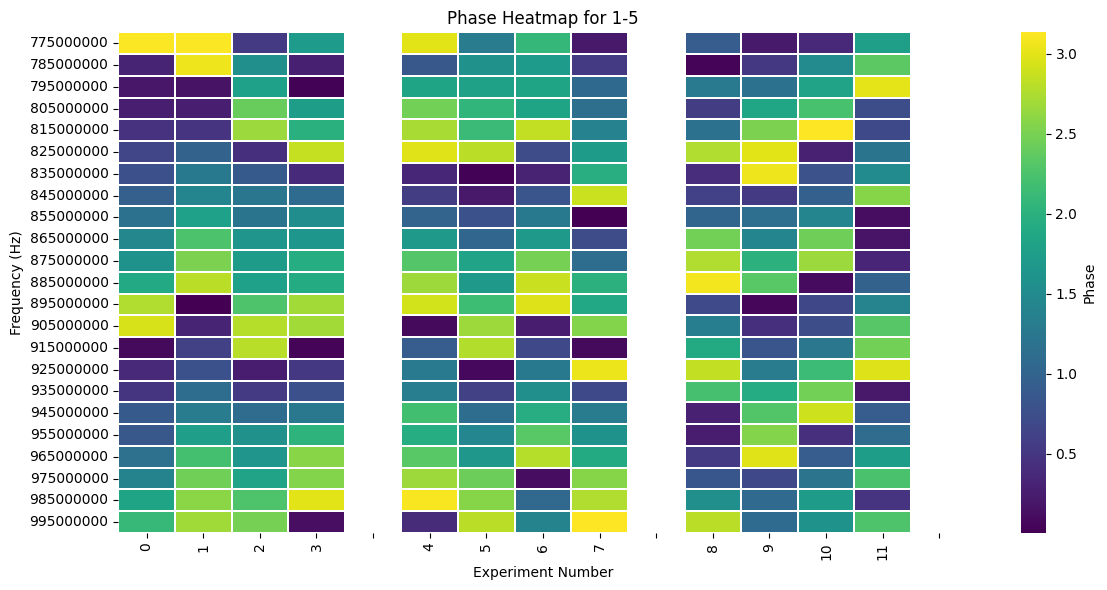

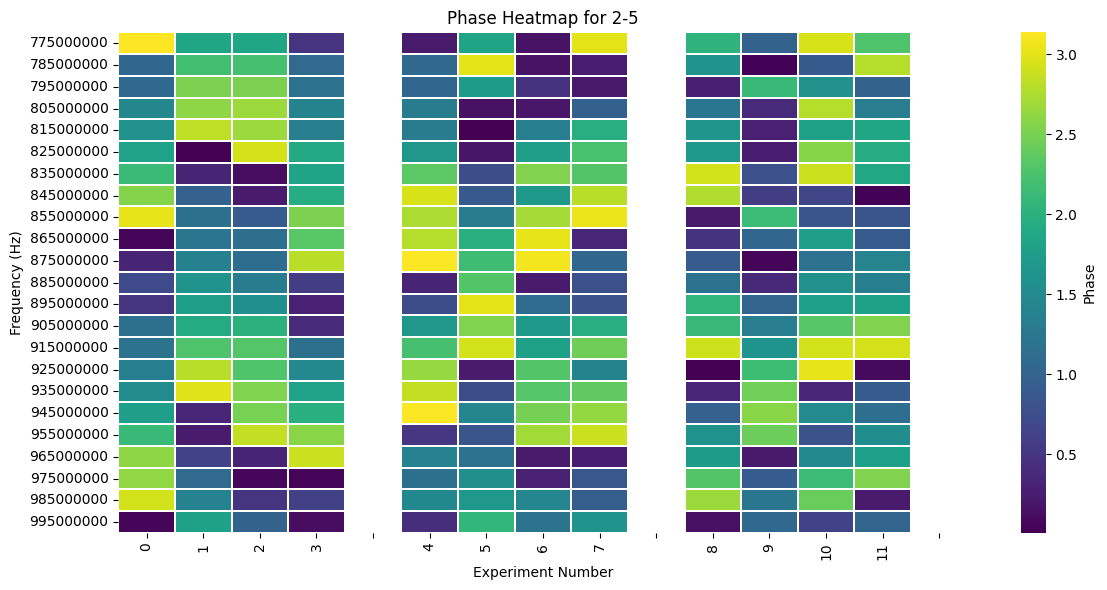

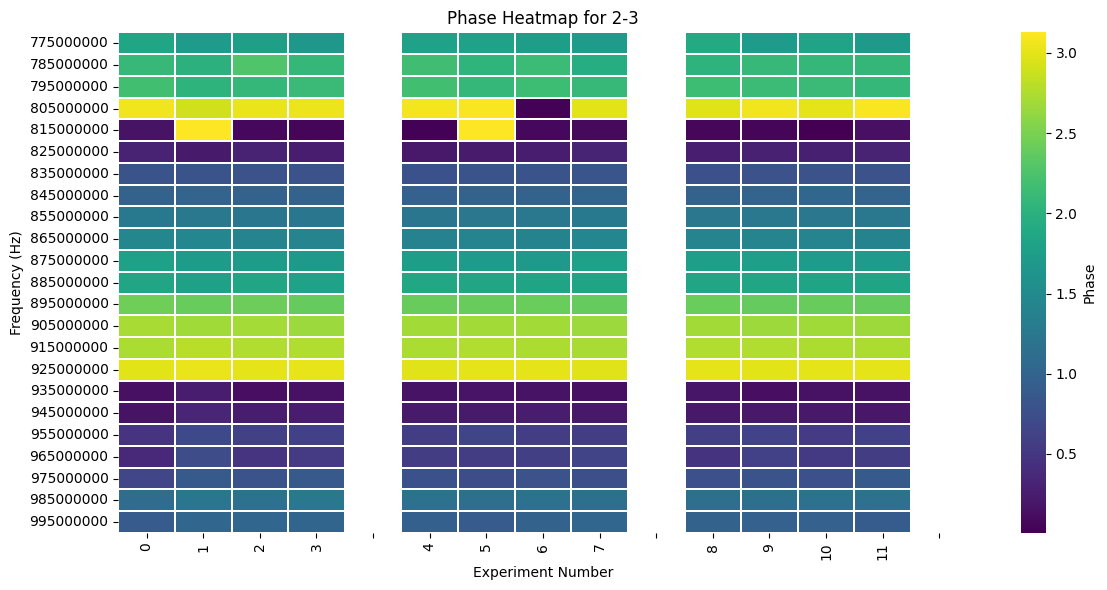

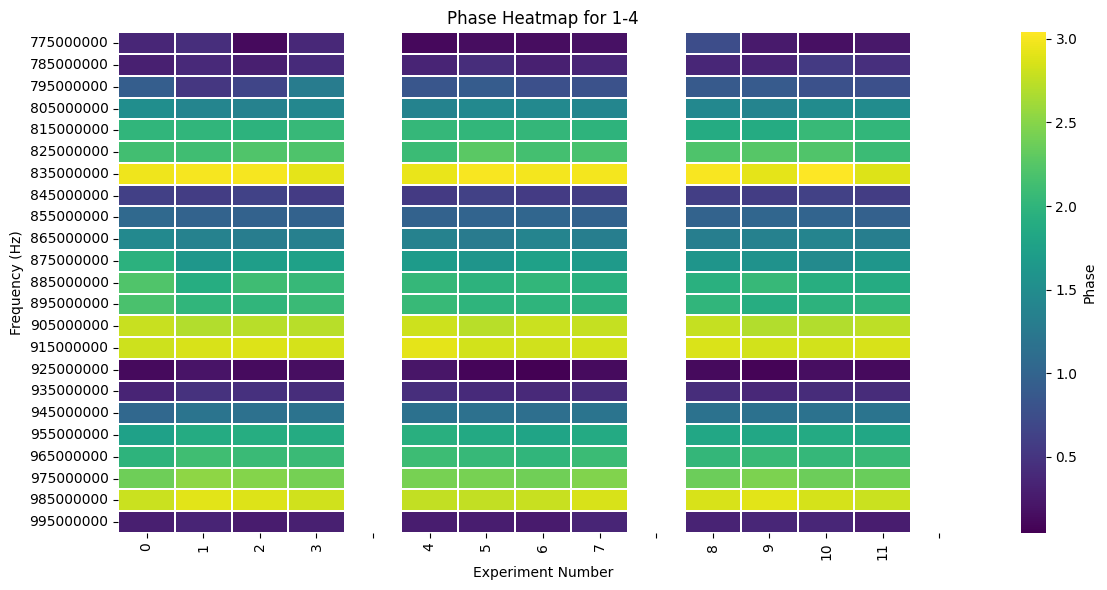

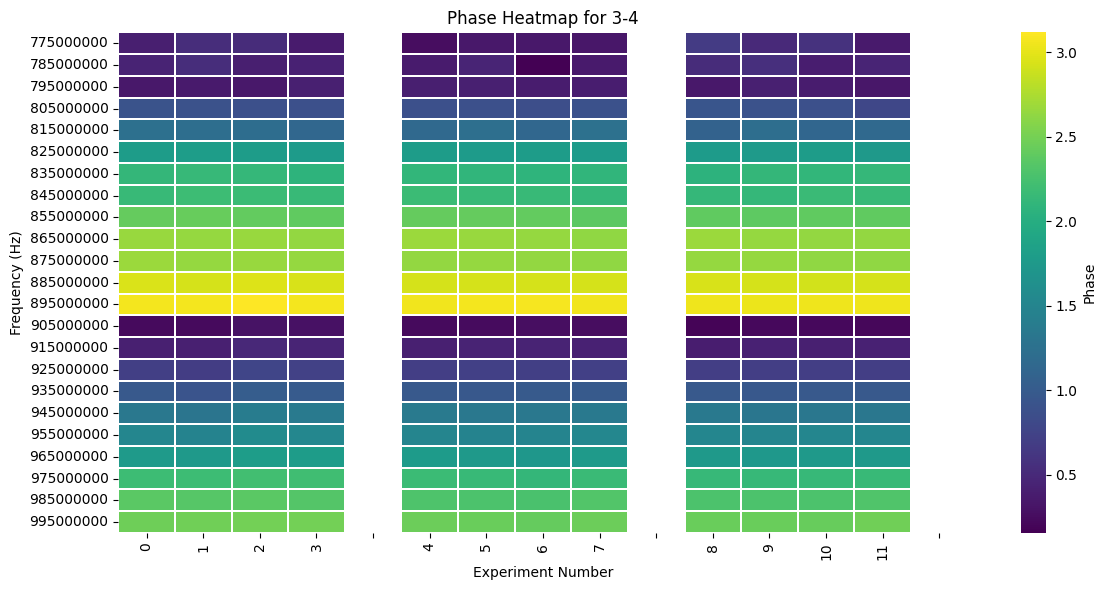

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phase_heatmaps(data):
    """
    data format:
    {
        freq: {
            exp_num: [ { "tagA-tagB": phase, ... } ]
        }
    }
    """

    # ---- Extract all tag pairs ----
    tag_pairs = set()
    for freq, exp_dict in data.items():
        for exp, tag_list in exp_dict.items():
            tag_pairs.update(tag_list[0].keys())

    frequencies = sorted(data.keys())
    experiment_numbers = sorted({exp for freq in data for exp in data[freq]})

    # ---- Build spacing-aware X-axis ----
    original_exps = experiment_numbers.copy()
    spaced_exps = []
    insert_positions = set()

    for i, exp in enumerate(experiment_numbers):
        spaced_exps.append(exp)
        if (i + 1) % 4 == 0:      # after every 4th experiment
            spaced_exps.append("")   # spacer label
            insert_positions.add(len(spaced_exps) - 1)

    # ---- Create heatmap for each tag ----
    for tag in tag_pairs:

        # Initialize heat matrix
        heat = np.full((len(frequencies), len(spaced_exps)), np.nan)

        for i, f in enumerate(frequencies):

            col = 0
            for j, exp in enumerate(original_exps):

                # Fill actual experiment column
                if exp in data[f]:
                    tag_dict = data[f][exp][0]
                    if tag in tag_dict:
                        heat[i, col] = tag_dict[tag]

                col += 1

                # If a spacer should be added here, skip one column
                if (j + 1) % 4 == 0:
                    col += 1

        # ---- Plot heatmap ----
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            heat,
            xticklabels=spaced_exps,
            yticklabels=frequencies,
            cmap="viridis",
            cbar_kws={"label": "Phase"},
            linewidths=0.2,
            linecolor="white"  # makes spacers more visible
        )

        plt.xlabel("Experiment Number")
        plt.ylabel("Frequency (Hz)")
        plt.title(f"Phase Heatmap for {tag}")

        # Rotate labels
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.show()

plot_phase_heatmaps(all_freqs)